# **Encontrando Quinas**

#### **Iremos aprender:**
1. Como usar o Detector de canto Harris
2. Use bons recursos para rastrear


In [1]:
# Our Setup, Import Libaries, Create our Imshow Function and Download our Images
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Define our imshow function 
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

# Download and unzip our images
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/images.zip
!unzip -qq images.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


## **O que são cantos?**

Um canto é um ponto cuja vizinhança local está em duas direções de borda dominantes e diferentes. Em outras palavras, um canto pode ser interpretado como a junção de duas bordas, onde uma borda é uma mudança repentina no brilho da imagem. Os cantos são as características importantes da imagem,
e são geralmente denominados como pontos de interesse que são invariantes à translação, rotação e iluminação.

Nas imagens, um canto é uma área onde duas bordas se encontram. Na verdade, o artigo original argumenta que os cantos devem ser a pedra angular (trocadilho intencional) da detecção de recursos porque possuem as seguintes características:

- Discretos – eles ocupam um espaço único e pequeno (não um continuum)
- Confiável - provavelmente re-aparecem em uma área semelhante quadro a quadro
- Significativo – cantos fortes geralmente vêm de objetos reais, e não de sombras ou iluminação

![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/edge.png)

### *Entendendo um pouco de gradiente*.

Um gradiente mede como os valores de intensidade (ou brilho) mudam em uma imagem.
Em um canto, os valores de intensidade mudam significativamente em múltiplas direções. Por isso, os gradientes são úteis para detectar cantos e bordas.

O operador Sobel (Filtro de convolução) é uma ferramenta usada para calcular os gradientes na direção horizontal (x) e vertical (y) de uma imagem.
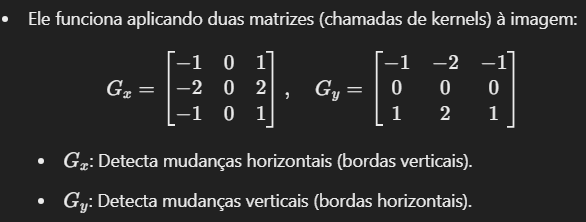


Em uma região de canto, tanto Gx quanto Gy têm valores significativos, pois as intensidades mudam em múltiplas direções.
Para destacar a intensidade total da mudança em um canto, calculamos a magnitude do gradiente:

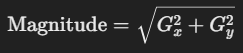

Além da magnitude, é possível determinar a direção do gradiente:

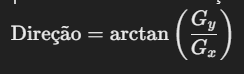

- Uma variação elevada nas direcções do gradiente x e y indica um canto

- Uma variação elevada em qualquer uma das direcções do gradiente x e y indica uma aresta

- A baixa variação nas direções do gradiente x e y indica uma
superfície









Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1015.0..1015.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1020.0..1020.0].


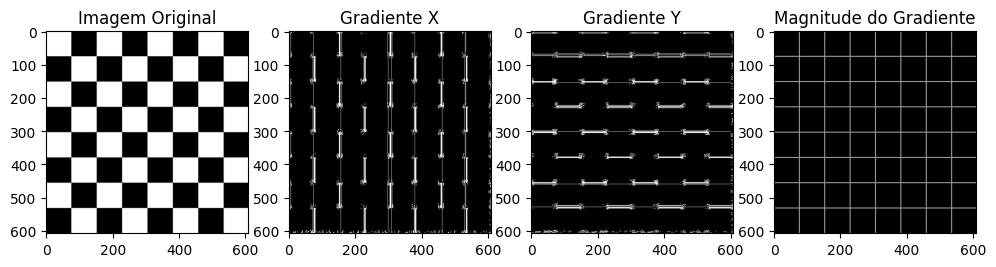

In [2]:
# Load image then grayscale

image = cv2.imread('images/chess.JPG')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#Kernel de Sobel 3
grad_cv2x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3) # Gradiente na direção x
grad_cv2y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3) # Gradiente na direção y


# Calcular a magnitude do gradiente
gradient_magnitude = np.sqrt(grad_cv2x**2 + grad_cv2y**2)
 # Normalizar para 0-255
gradient_magnitude = np.uint8(gradient_magnitude / gradient_magnitude.max() * 255) 


# Calcular a direção do gradiente (opcional)
gradient_direction = np.arctan2(grad_cv2y, grad_cv2x)

# Definir um limite para considerar apenas gradientes significativos
threshold = gradient_magnitude.max() * 0.0  # 20% do valor máximo
significant_gradients = gradient_magnitude > threshold

# Extrair os valores significativos de Gx e Gy
significant_Gx = grad_cv2x[significant_gradients]
significant_Gy = grad_cv2y[significant_gradients]

# Exibir os resultados
plt.figure(figsize=(12, 8))
plt.subplot(1, 4, 1), plt.title('Imagem Original'), plt.imshow(image, cmap='gray')
plt.subplot(1, 4, 2), plt.title('Gradiente X'), plt.imshow(grad_cv2x, cmap='gray')
plt.subplot(1, 4, 3), plt.title('Gradiente Y'), plt.imshow(grad_cv2y, cmap='gray')
plt.subplot(1, 4, 4), plt.title('Magnitude do Gradiente'), plt.imshow(gradient_magnitude, cmap='gray')
plt.show()

Cada ponto no scatter plot representa um pixel na imagem onde o gradiente foi significativo.

O gráfico ajuda a entender a distribuição dos gradientes significativos na imagem.
Áreas com alta magnitude do gradiente (bordas ou cantos) terão pontos mais densos.
Definimos um limite (threshold) como 20% do valor máximo da magnitude do gradiente para filtrar apenas os gradientes mais relevantes.

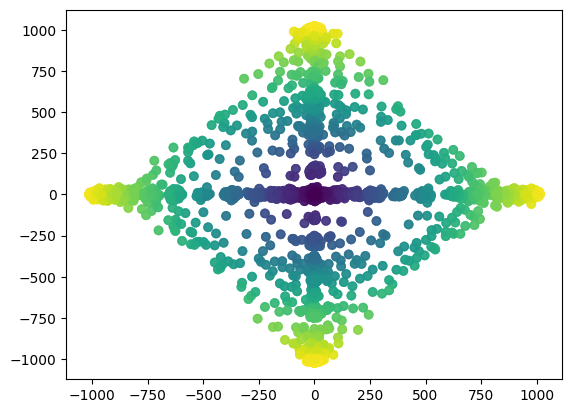

In [4]:
plt.scatter(significant_Gx, significant_Gy, alpha=0.6, c=gradient_magnitude[significant_gradients], cmap='viridis')

### **Harris Corner Detection** é um algoritmo desenvolvido em 1988 para detecção de cantos que funciona bem.

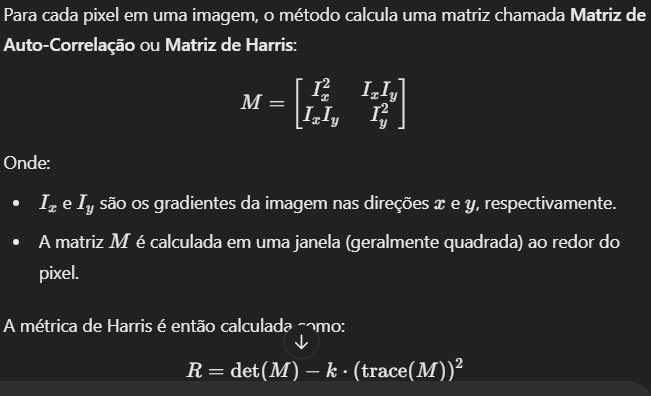

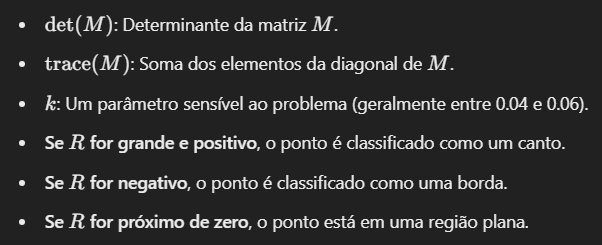

**Paper** - https://web.stanford.edu/class/cs231m/references/harris-stephens.pdf


**cv2.cornerHarris**(input image, block size, ksize, k)
- Input image - should be grayscale and float32 type.
- blockSize - Tamanho da vizinhança 
- ksize - parâmetro de abertura da derivada de Sobel usado.
- k - parâmetro livre do detector Harris na equação
- **Output** – array das localizações de pixel (x,y)




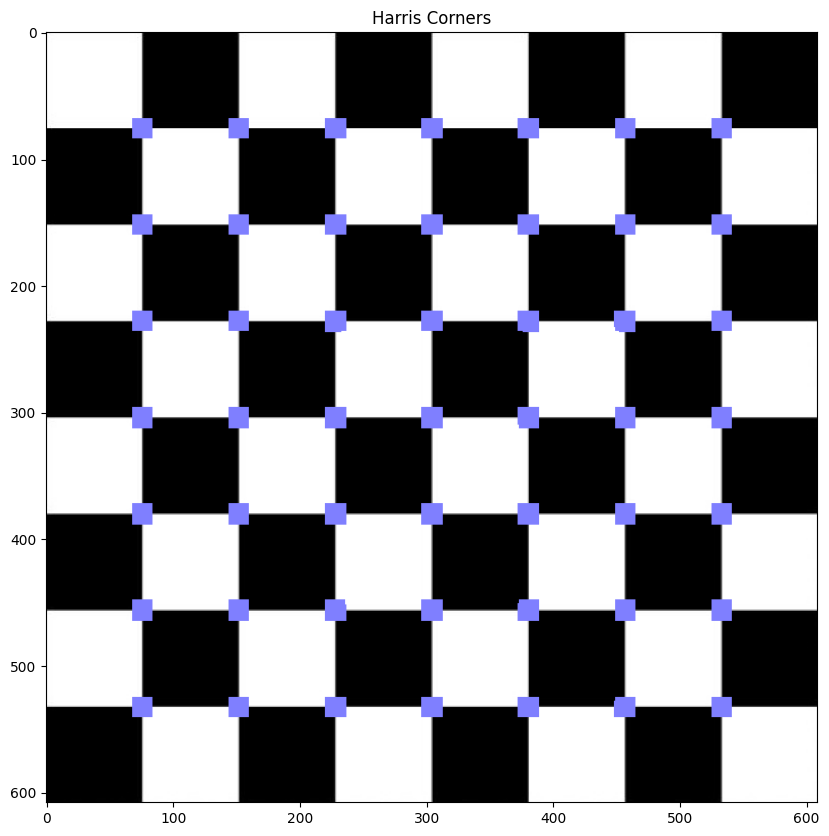

In [53]:
# Load image then grayscale
image = cv2.imread('images/chess.JPG')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Converter a imagem a um array com valores do tipo float32
gray = np.float32(gray)

harris_corners = cv2.cornerHarris(gray, 3, 3, 0.05)

#Usamos a dilatação dos pontos dos cantos para ampliá-los\
kernel = np.ones((7,7),np.uint8)
harris_corners = cv2.dilate(harris_corners, kernel, iterations = 2)

# Limite para um valor ideal, pode variar dependendo da imagem.
image[harris_corners > 0.025 * harris_corners.max() ] = [255, 127, 127]

imshow('Harris Corners', image)

**cv2.goodFeaturesToTrack**(input image, maxCorners, qualityLevel, minDistance)

## **Essa função aplica o Shi-Tomasi Corner Detector !**

PEGAMOS O GRADIENTE: A imagem é analisada em pequenos blocos para calcular derivadas em X e Y. Isso identifica variações na intensidade dos pixels.
Para cada pixel, é construída uma matriz com os gradientes

Critério de Shi-Tomasi -> Shi-Tomasi seleciona os pontos baseados no menor autovalor (λ) da matriz.

Os pontos são classificados pela qualidade e aplicam-se os critérios de qualidade mínima e distância mínima para filtrar os melhores pontos.


- Input Image - 8-bit or floating-point 32-bit, single-channel image.

- maxCorners – Número máximo de cantos a devolver. Se houver mais cantos do que os encontrados, o mais forte deles será retornado.

- qualityLevel – Parâmetro que caracteriza a qualidade mínima aceita dos cantos da imagem. O valor do parâmetro é multiplicado pela melhor medida de qualidade de canto (menor autovalor). Os cantos com medida de qualidade inferior ao produto são rejeitados. Por exemplo, se o melhor canto tiver a medida de qualidade = 1500 e o nível de qualidade = 0,01, somente pontos cuja resposta seja maior que 1% do ponto com a melhor resposta serão mantidos.

- minDistance – Distância euclidiana mínima possível entre os cantos retornados.


Retorno: Um array (N x 1 x 2) com as coordenadas (x,y) dos pontos detectados.


66
[[76. 75.]]
[[380.  75.]]
[[ 76. 151.]]
[[152.  76.]]
[[304.  76.]]
[[532.  75.]]
[[381. 533.]]
[[456.  76.]]
[[228.  75.]]
[[381. 303.]]
[[380. 152.]]
[[381. 227.]]
[[381. 457.]]
[[151. 151.]]
[[ 76. 533.]]
[[457. 533.]]
[[532. 151.]]
[[151. 533.]]
[[381. 381.]]
[[457. 227.]]
[[457. 151.]]
[[227. 151.]]
[[ 76. 227.]]
[[227. 533.]]
[[ 76. 304.]]
[[ 76. 456.]]
[[227. 227.]]
[[533. 533.]]
[[303. 303.]]
[[151. 227.]]
[[305. 457.]]
[[532. 227.]]
[[305. 379.]]
[[304. 532.]]
[[227. 381.]]
[[304. 151.]]
[[227. 457.]]
[[ 76. 380.]]
[[303. 227.]]
[[151. 457.]]
[[227. 303.]]
[[151. 303.]]
[[457. 303.]]
[[456. 380.]]
[[533. 457.]]
[[457. 457.]]
[[532. 304.]]
[[151. 381.]]
[[533. 380.]]
[[  2. 153.]]
[[  2. 305.]]
[[606.  77.]]
[[606. 302.]]
[[606. 454.]]
[[  2. 458.]]
[[  1. 223.]]
[[378.   2.]]
[[533.   2.]]
[[227.   2.]]
[[456. 605.]]
[[1. 2.]]
[[75.  2.]]
[[457.   2.]]
[[151.   2.]]
[[305.   3.]]
[[ 76. 605.]]


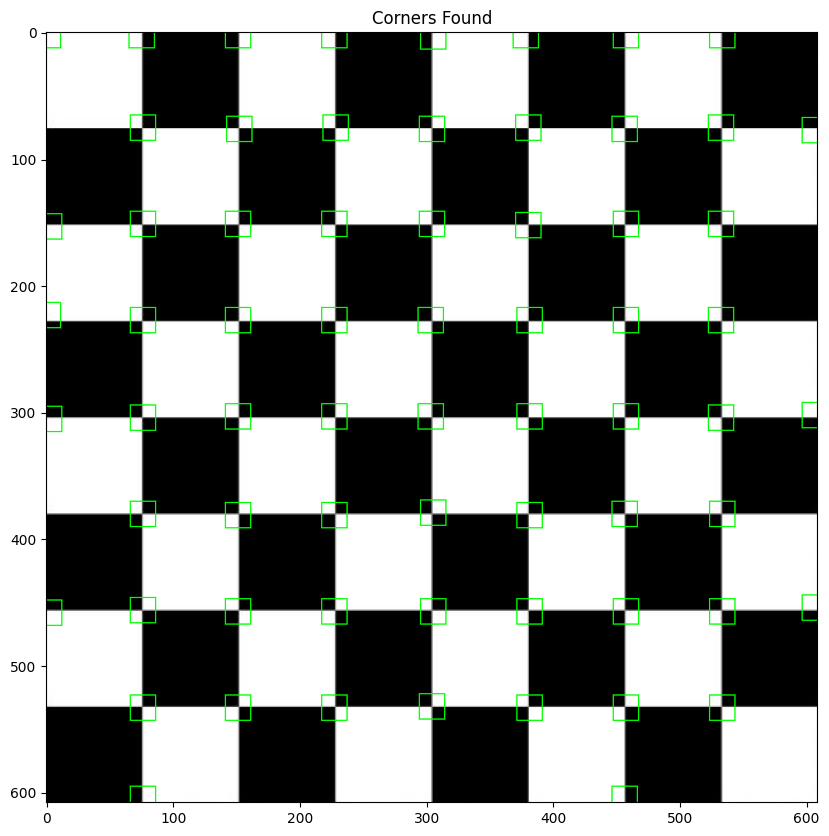

In [3]:
img = cv2.imread('images/chess.JPG')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# We specific the top 50 corners
corners = cv2.goodFeaturesToTrack(gray, 150, 0.0005, 10)

print(len(corners))

for corner in corners:
    print(corner)
    x, y = corner[0]
    x = int(x)
    y = int(y)
    cv2.rectangle(img,(x-10,y-10),(x+10,y+10),(0,255,0), 0)
    
imshow("Corners Found", img)